In [1]:
# Install required packages
# !pip install requests pillow scikit-image lime tensorflow

# Explainable AI Workshop
Welcome to the Explainable AI workshop! In this notebook, you will learn how to interpret machine learning models using feature importance and LIME. We will use Random Forests and Neural Networks as examples.

## 1. Import Required Libraries
Let's start by importing all the necessary libraries for this workshop.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lime.lime_tabular import LimeTabularExplainer

## 2. Load and Prepare Dataset
We will use the Breast Cancer dataset from scikit-learn. Let's load the data and split it into training and test sets.

In [3]:
# Load dataset
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (455, 30), Test shape: (114, 30)


## 3. Train Random Forest Model
Let's train a Random Forest classifier and evaluate its accuracy.

In [4]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {acc_rf:.2f}")

Random Forest Test Accuracy: 0.96


## 4. Visualize Feature Importance (Random Forest)
Let's see which features are most important for the Random Forest model.

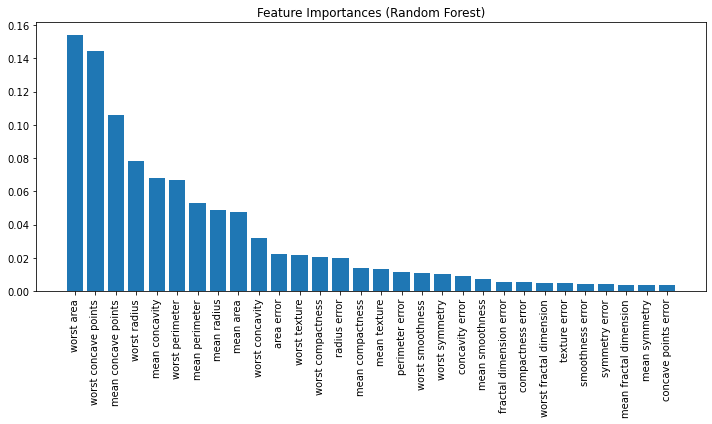

In [5]:
# Plot feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

## 5. Train Neural Network Model
Now let's build and train a simple neural network using Keras.

In [6]:
# Build and train neural network
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

model.summary()

# Evaluate on test set
loss, acc_nn = model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network Test Accuracy: {acc_nn:.2f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Neural Network Test Accuracy: 0.95


## 6. Apply LIME to Neural Network Predictions
Let's use LIME to explain the predictions made by our neural network on some test samples.

In [7]:
# LIME explanation for neural network
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['malignant', 'benign'],
    mode='classification'
)

def nn_predict_proba(x):
    return np.hstack([(1-model.predict(x)), model.predict(x)])

# Pick a test sample
sample_idx = 1
# sample_idx = 42
# sample_idx = 20

sample = X_test.iloc[sample_idx].values.reshape(1, -1)
y_sample = y_test.iloc[sample_idx]
pred = model.predict(sample, verbose=0)[0][0]

print(f"Actual label: {'Benign' if y_sample == 1 else 'Malignant'}")
print(f"Model prediction: {'Benign' if pred > 0.5 else 'Malignant'} (probability: {pred:.3f})")

exp = explainer.explain_instance(sample[0], nn_predict_proba, num_samples=5000, num_features=10)
exp.show_in_notebook(show_table=True)

Actual label: Malignant
Model prediction: Malignant (probability: 0.000)
157/157 [==============================] - 0s 2ms/step


## 7. Interpret LIME Explanations

The LIME visualization above shows two key pieces of information:

1. **The Plot**: 
   - Orange/Green bars show feature contributions
   - Orange bars (positive values) push the prediction toward class 1 (benign)
   - Green bars (negative values) push the prediction toward class 0 (malignant)
   - Longer bars mean stronger influence on the prediction
   - Features are ordered by importance (strongest influence first)

2. **The Table**:
   - Shows the actual values for each feature
   - Positive weights support benign prediction
   - Negative weights support malignant prediction

For example, if you see a large orange bar for "mean radius" with a low value, this means that having a small tumor radius strongly suggests the tumor is benign.

Try changing the sample index to see explanations for other samples! This helps you understand how the model makes different predictions based on different feature values.

## 8. Explainable AI for Images: ResNet & LIME
In this section, we'll use a pre-trained ResNet model to classify an image, and then apply LIME to visualize which superpixels influenced the prediction.

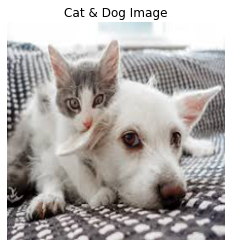

In [8]:
# Download and preprocess image
import requests
from PIL import Image
from io import BytesIO
import numpy as np

# Download a sample cat & dog image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTz45-3oZW3yY8BcW6LuyOhcHqZ2wvaoB7XtQ&s'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')
img = img.resize((224, 224))
img_np = np.array(img)

plt.imshow(img_np)
plt.axis('off')
plt.title('Cat & Dog Image')
plt.show()

In [9]:
# Load ResNet model and predict
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

img_batch = np.expand_dims(img_np, axis=0)
img_preprocessed = preprocess_input(img_batch)

model_resnet = resnet50.ResNet50(weights='imagenet')
preds = model_resnet.predict(img_preprocessed, verbose=0)

# Decode predictions
for pred in decode_predictions(preds, top=3)[0]:
    print(f"Predicted: {pred[1]} ({pred[2]*100:.2f}%)")

Predicted: Angora (13.07%)
Predicted: doormat (11.27%)
Predicted: Scotch_terrier (10.56%)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


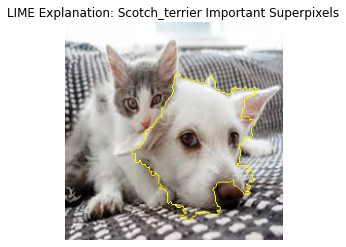

In [10]:
# Use LIME to explain ResNet prediction
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer_img = lime_image.LimeImageExplainer()

# Define prediction function for LIME
predict_fn = lambda imgs: model_resnet.predict(preprocess_input(imgs))

explanation = explainer_img.explain_instance(
    img_np,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

class_id = 2
# Show explanation for top predicted label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[class_id],
    positive_only=True,
    num_features=3,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'LIME Explanation: {decode_predictions(preds, top=3)[0][class_id][1]} Important Superpixels')
plt.axis('off')
plt.show()